In [26]:
import h5py as h5
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    validation_curve,
    train_test_split,
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    log_loss,
)
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [27]:
np.random.seed(42)

In [28]:
# Grab extracted features and labels (TRAIN SET).
with h5.File('features_train.h5', 'r') as file:
    X_train, y_train = file['images'][:], file['labels'][:]
    classes = file['classes'][:]

### Logistic Regression

In [29]:
# Params used to find the best estimator.
params = {
    'C': [0.0001, 0.001, 0.01, 0.01, 1.0, 10.0, 100.0, 1000.0]
}

model = GridSearchCV(
    LogisticRegression(
        solver='lbfgs',
        multi_class='auto',
        max_iter=1000,
    ),
    param_grid=params,
    cv=3,
    n_jobs=-1, # -1: all cores
    verbose=2,
)

In [30]:
model.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:   26.6s remaining:   19.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   36.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.01, 1.0, 10.0, 100.0,
                               1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [31]:
print('Best estimator is', model.best_estimator_)
print('Best score is', model.best_score_)

Best estimator is LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best score is 0.9417670682730924


### Train the best model

In [32]:
best_model = model.best_estimator_

best_model.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Cross-Validation Score

In [33]:
cvscore = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

In [34]:
f'Cross Validation Score is ~{round(np.average(cvscore), 3) * 100}%.'

'Cross Validation Score is ~94.19999999999999%.'

### Confusion matrix

In [35]:
y_train_preds = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
)

In [36]:
confusion_matrix(y_train, y_train_preds)

array([[227,  22],
       [  7, 242]])

### Precision

In [37]:
precision_score(y_train, y_train_preds)

0.9166666666666666

### Recall

In [38]:
recall_score(y_train, y_train_preds)

0.9718875502008032

### F1-Score (harmonic mean)

In [39]:
f1_score(y_train, y_train_preds)

0.9434697855750487

### Precision recall curve

In [40]:
y_scores = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    method='decision_function',
    n_jobs=-1,
)

In [41]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

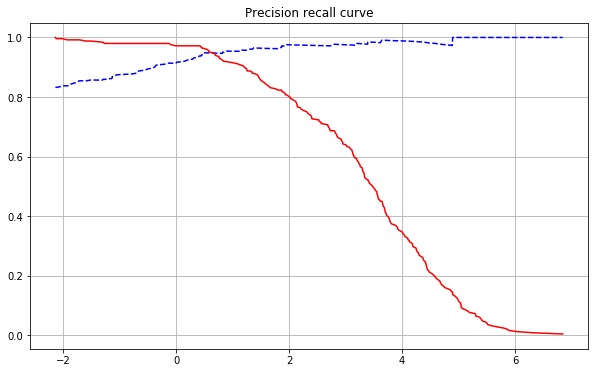

In [42]:
plt.figure(figsize=(10, 6))
plt.title('Precision recall curve')
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.grid()
plt.show()

### ROC Curve

In [43]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

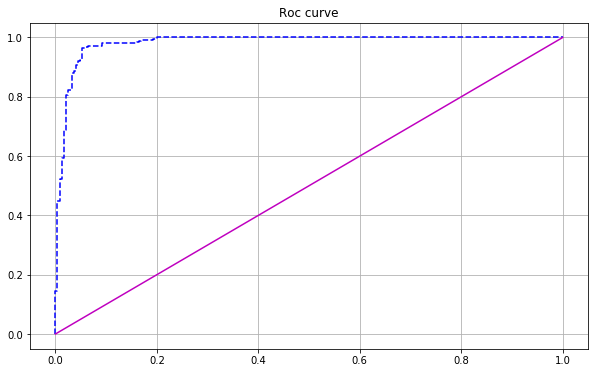

In [44]:
plt.figure(figsize=(10, 6))
plt.title('Roc curve')
plt.plot(fpr, tpr, 'b--')
plt.plot([0, 1], [0, 1], 'm-')
plt.grid()
plt.show()

### ROC-AUC Score

In [45]:
roc_auc_score(y_train, y_scores)

0.982500282253512

### Learning curve

In [46]:
lrn_curve = learning_curve(
    best_model,
    X_train,
    y_train,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
)

In [47]:
train_sizes_abs, train_scores, val_scores = lrn_curve

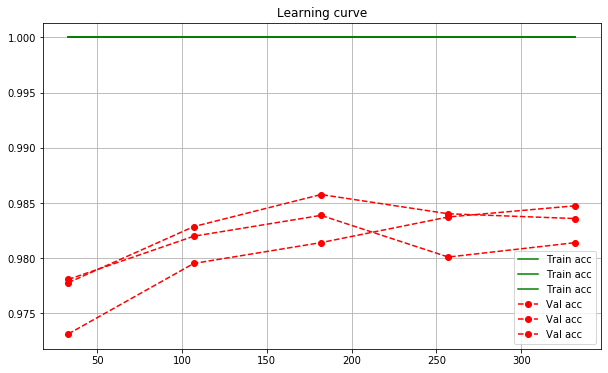

In [48]:
plt.figure(figsize=(10, 6))
plt.title('Learning curve')
plt.plot(train_sizes_abs, train_scores, 'g-', label='Train acc')
plt.plot(train_sizes_abs, val_scores, 'ro--', label='Val acc')
plt.legend(loc='best')
plt.grid()
plt.show()

In [53]:
def plot_learning_curves(model, X, y):
    X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.2)
    train_loss = []
    val_loss = []
    
    for m in np.linspace(2, len(X_train)-2, 20, dtype=int):
        model.fit(X_t[:m], y_t[:m])
        y_train_predict = model.predict(X_t[:m])
        y_val_predict = model.predict(X_v)
        train_loss.append(log_loss(y_t[:m], y_train_predict))
        val_loss.append(log_loss(y_v, y_val_predict))
    
    plt.figure(figsize=(10, 6))
    plt.title('Learning curve')
    plt.plot(train_loss, 'r-+', label='Train Loss')
    plt.plot(val_loss, 'b-', label='Val Loss')
    plt.legend(loc='best')
    plt.show()

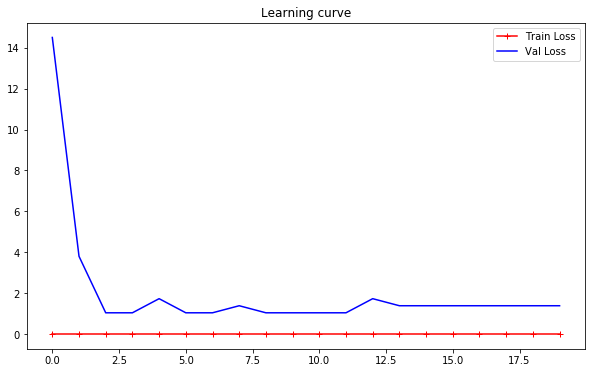

In [54]:
plot_learning_curves(best_model, X_train, y_train)